In [1]:
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tic_env import TictactoeEnv, OptimalPlayer

# 2. Q-learning

## 2.1 Learning from experts

In [2]:
def grid_to_string(grid):
    char_rep= {0:'-', 1: 'X',-1:'O'}
    return ''.join([char_rep[x] for x in grid.flatten()])

In [3]:
def action_to_key(action,  state):
    if type(action) is tuple:
        action = action[0]*3 + action[1]
    return (action, grid_to_string(state))

In [4]:
def get_state_best_Q(state, Q_vals, player_rnd):
    
    pot_actions = player_rnd.empty(state)
     # optimal choice wrt policy (eps-greedy)
    best_Q = -math.inf
    best_key = None

    for a in pot_actions:                    
        key = action_to_key(a, state)

        Q_a = Q_vals.get(key, 0)

        if (Q_a > best_Q):
            best_Q = Q_a
            best_key = key
    return best_key, best_Q

In [5]:
# Q-learning algo

max_game_length = 9

lr = 0.05
df = 0.99
epsilon_greed = 0.2 #set in [0 ; 1[

Q_vals = {}
Turns = np.array(['X','O'])

seed = 42
rng = default_rng(seed)
env = TictactoeEnv()

avg_reward = []
avg_step = 250 
acc_reward = 0

for ep in range(0, 20000):
    if ((ep+1)%avg_step==0):
        avg_reward.append(acc_reward/avg_step)
        acc_reward = 0
        
    player_opt = OptimalPlayer(epsilon=0, player=Turns[ep%2])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[(ep+1)%2])
    
    pred_key, pred_rew  = None, None
    for j in range(max_game_length):
        if env.current_player == player_opt.player:
            move = player_opt.act(env.grid)
            
        else:
            #update Q-val
            if(j != 0 and j!=1):
                Q_v = Q_vals.get(pred_key, 0.0)
                Q_vals[pred_key] = Q_v + lr * (pred_rew + df * get_state_best_Q(env.grid, Q_vals, player_rnd)[1] - Q_v) 

            if(rng.uniform() <= epsilon_greed):
                move = player_rnd.act(env.grid)
            else:
                key, _ = get_state_best_Q(env.grid, Q_vals, player_rnd)
                move = key[0]
                
        prev_grid = env.grid.copy()
        grid, end, winner = env.step(move, print_grid=False)
        
        if env.current_player == player_rnd.player:
            pred_key = action_to_key(move, prev_grid)
            pred_rew = env.reward(player_rnd.player)        
    
        if end:
            '''print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            
            # rewards handling -> env.winner
            
            env.render()
            if(env.winner == player_rnd.player):
                print('won')'''
            
            key = action_to_key(move, prev_grid)
            Q_v = Q_vals.get(key,0.0)
            Q_vals[key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            acc_reward += env.reward(player_rnd.player)
            env.reset()
            break

In [6]:
Q_vals

{(8, 'O---X----'): 0.0,
 (2, 'OO--X---X'): 0.0,
 (5, 'OOXOX---X'): -0.9999999999999989,
 (4, 'X--------'): 0.0,
 (6, 'X--XO----'): 0.0,
 (2, 'XX-XO-O--'): -0.9999999888486593,
 (5, 'OOX-X-O-X'): -0.9992771830207938,
 (2, 'XX--O----'): 0.0,
 (6, 'XXOXO----'): -0.9999999999999989,
 (4, 'O-X------'): 0.0,
 (6, 'OOX-X----'): -0.9999999999999989,
 (2, 'X---OX---'): 0.0,
 (6, 'XXO-OX---'): -0.9999999999999903,
 (4, '---O----X'): 0.0,
 (6, 'O--OX---X'): 0.0,
 (2, 'OO-OX-X-X'): -0.9843103943342372,
 (4, 'XO-------'): 0.0,
 (8, 'XOO-X----'): -0.9999999999999989,
 (4, '--X------'): 0.0,
 (0, '--XXO----'): 0.0,
 (8, 'OXXXO----'): -0.7496559102575447,
 (4, 'O-----X--'): 0.0,
 (2, 'OO--X-X--'): -0.9999999999999989,
 (6, 'OOXOX---X'): -0.9999999999999989,
 (1, 'O-O-X---X'): 0.0,
 (7, 'OXO-XO--X'): -0.2262190625,
 (6, 'X-O-OX--X'): -0.8062885155414988,
 (4, '------X--'): 0.0,
 (3, 'X---O-X--'): 0.0,
 (5, 'X-XOO-X--'): -0.6764664550262907,
 (4, '-X-------'): 0.0,
 (4, 'O-------X'): 0.0,
 (4, '--X--O--

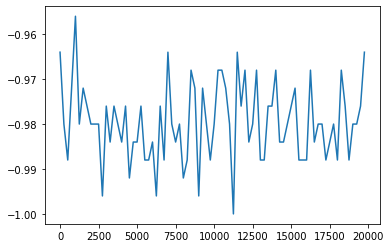

In [7]:
plt.plot(range(0, 20000, 250), avg_reward)

In [8]:
np.mean(np.array(avg_reward))

-0.9795999999999999

In [4]:
def grid_to_string(grid):
    char_rep= {0:'-', 1: 'X',-1:'O'}
    return ''.join([char_rep[x] for x in grid.flatten()])

In [5]:
def action_to_key(action, player, state):
    if type(action) is tuple:
        action = action[0]*3 + action[1]
    return ((action, player), grid_to_string(state))

In [6]:
def get_state_best_Q(state, Q_vals, player_rnd):
    
    pot_actions = player_rnd.empty(state)
     # optimal choice wrt policy (eps-greedy)
    best_Q = -math.inf
    best_key = None

    for a in pot_actions:                    
        key =action_to_key(a, player_rnd.player, state)

        Q_a = Q_vals.get(key, 0)

        if (Q_a > best_Q):
            best_Q = Q_a
            best_key = key
            
    return best_key, best_Q

In [7]:
# Q-learning algo
Turns = np.array(['X','O'])

# repeat for each episode



for ep in range(0, 200):
    # Init the game
    env.reset()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0, player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    
    pred_key, pred_rew  = None, None
    for j in range(max_game_length):
        if env.current_player == player_opt.player:
            move = player_opt.act(env.grid)
        else:
            
            #update Q-val
            if(j != 0 and j!=1):
                Q_v = Q_vals.get(pred_key,0.0)
                Q_vals[pred_key] = Q_v + lr * (pred_rew + df * get_state_best_Q(env.grid, Q_vals, player_rnd)[1] - Q_v) 

            if(rng.uniform() <= epsilon_greed):
                move = player_rnd.act(env.grid)
            else:       
                key, _ = get_state_best_Q(env.grid, Q_vals, player_rnd)
                move = key[0][0]
                
        prev_grid = env.grid.copy()
        grid, end, winner = env.step(move, print_grid=False)
        
        if env.current_player == player_rnd.player:
            pred_key = action_to_key(move, player_rnd.player, prev_grid)
            pred_rew = env.reward(player_rnd.player)        
    
        if end:
            '''print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            
            # rewards handling -> env.winner
            
            env.render()'''
            env.reset()
            break